# Credit Risk Mortgage Loans
The data is provided by [Home Credit](https://www.homecredit.net/about-us.asp), who provides lines of credit (loans) to the unbanked population. There are 307,511 rows of different credit information and 122 columns of feature variables. 

Using different models using AUC found the following:
* Linear regression 0.7327
* Decision tree 0.7215
* Gradient boost 0.6966
* Random forest 0.6312
* Logistic regression 0.6145
* Knn 0.5106 
* SVM has runtime memory issues from too big data. 

A final credit prediction will be made for every test data.

## Datasets Summary
Original dataset csv files can be found on [Kaggle](https://www.kaggle.com/c/home-credit-default-risk). The columns with first five rows will be shown below to view whenever a dataset is used. Therefore, one will not have to download the csv files. There are seven sources of data for this project which will be briefly
described below:
* Train.csv: This is the most important dataset with 307,511 rows which are house data. There are 106 column features describing houses such as square feet and year built. The column TARGET column is an important feature to discuss. A 1 in this row means the loan struggled to payback. A 0 means the loan was did not default. Some of the features will need to be encoded numerical to test if they have high feature importance.
* bureau.csv: Other previous credit data from other financial institutions. 
* bureau_balance.csv: Monthly bureau previous credits.
* brevious_application.csv: Previous application loans.
* POS_CASH_BALANCE.csv: Monthly data about previous cash loans. 
* credit_card_balance.csv: Monthly credit card data for clients with Home Credit.
* installments_payment.csv: Payment history for previous loans.
<br/> <br/>

## View Train Data
The training dataset is the most important dataset with over three-hundred thousand house prices that will be predicted at the very using the best metrics predictive models with reduced error. In total, the train data has 122 columns with 307,511 rows of credit. The first five rows of the train.csv file will be shown below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
#sample=r'/kaggle/input/home-credit-default-risk/sample_submission.csv'
#cash=r'/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv'
#info='/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv'
#app=r'/kaggle/input/home-credit-default-risk/previous_application.csv'
#cc=r'/kaggle/input/home-credit-default-risk/credit_card_balance.csv'
#install=r'/kaggle/input/home-credit-default-risk/installments_payments.csv'
bureau_balance=r'/kaggle/input/home-credit-default-risk/bureau_balance.csv'
train=r'/kaggle/input/home-credit-default-risk/application_train.csv'
test=r'/kaggle/input/home-credit-default-risk/application_test.csv'

data=pd.read_csv(train) # (307511, 122)
testDF=pd.read_csv(test)
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
data.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

## Examine TARGET column
How many loans were not repaid? In train.csv 0 stands for repaid and 1 stands for payment difficulties. The percent of loans that defaulted was 0.081. This is somewhat unbalanced data so we must be careful when selecting what metrics to use to analyze the data. In addition, we must consider other data files for feature importance. There are no missing TARGET values which is good because we would likely have to drop a row that does not have an independent variable.

In [3]:
temp=data['TARGET'].value_counts()
print(temp)
paid=temp[0]
notPaid=temp[1]
default=round(notPaid/(paid+notPaid),3)
print("Percent of loans that defauled: ", default)

0    282686
1     24825
Name: TARGET, dtype: int64
Percent of loans that defauled:  0.081


## Numeric DataFrame
The data is now all numeric values. We can encode categorical values later on to view if any of the categorical values have any importance worth investing in later.

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = data.select_dtypes(include=numerics) # (307511, 106)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Find missing values
Too many missing values on a column will get the column removed. In this case, there were about forty columns with more than 50% missing data. In total, there are 60 numeric columns with missing data, we need to interpret the Bureau to find feature importance in order to engineer which columns are most worth keeping.

In [5]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head(40))
findNA() 

Missing data by column as a percent:
COMMONAREA_MODE             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
FLOORSMIN_MEDI              0.678486
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_MODE            0.664978
YEARS_BUILD_AVG             0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_AVG                0.593767
LANDAREA_MEDI               0.593767
LANDAREA_MODE               0.593767
BASEMENTAREA_MEDI           0.585160
BASEMENTAREA_AVG            0.585160
BASEMENTAREA_MODE           0.585160
EXT_SOURCE_1                0.563811
NONLIVINGAREA_MODE          0.551792
NONLIVINGAREA_MEDI          0.551792
NONLIVINGAREA_AVG           0.551792
E

## Fix Missing Values
Variable number can be changed to delete a missing column with more than 20 NA values. Then, the dataframe must be filled in the mean for the remaining missing values. Since we need a final credit prediction for every credit loan, we can simply not delete any rows.

In [6]:
number=500 #remove col with  or more missing values
df = df[df.isnull().sum(axis=1) <= number] 
df= df.fillna(df.mean())
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


## Heat Map Correlations and Multicollinearity
There is no major multicollinearity. In fact, there are not many correlated variables. The following heatmap is set for correlations above .05 because there are so few variables that are highly correlated.

AxesSubplot(0.125,0.125;0.62x0.755)
Top 10 Correlations:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64


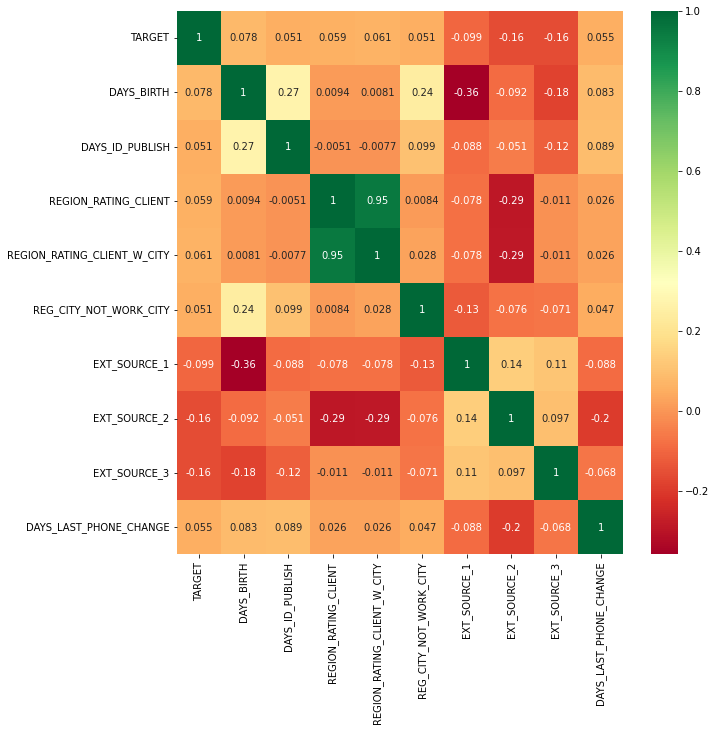

In [7]:
def printHeat():
    corr = df.corr()
    #print(corr)
    y='TARGET'
    highly_corr_features = corr.index[abs(corr[y])>0.05]
    plt.figure(figsize=(10,10))
    heat = sns.heatmap(df[highly_corr_features].corr(),annot=True,cmap="RdYlGn")
    top10=corr[y].sort_values(ascending=False).head(10)
    print(heat)
    print("Top 10 Correlations:\n", top10) # top ten correlations
printHeat()

## Split Data
Split the data set into training data and test data. TARGET will always be Y since it is the independent variable. A 1 is a troubled loan while a 0 equals a not distressed loan. 

In [8]:
X=df.drop('TARGET', axis=1)
y=df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

## Gradient Booster and Feature Importance
The amount of annuity and days_birth (age) are the two most highly correlated features. However, since this is unbalanced data there do not seem to be many feature importance to begin with.

Gradient boosting regression r2:  0.0048
AUC for gradient boost is:  0.7003
The mean squared error (MSE) on test set: 0.0742


Text(0.5, 1.0, 'Feature Importance (MDI)')

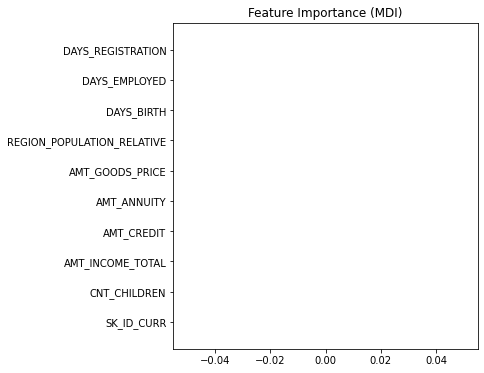

In [9]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

params = {
 "n_estimators": 5, "max_depth": 4, "min_samples_split": 5, "learning_rate": 0.01,
}

#Fit and Predict:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

#Calculate Metrics:
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

auc = round(metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for gradient boost is: ", auc)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

#FEATURE IMPORTANCE:
num=10 # How many features?
cols=X.columns
feature_importance = reg.feature_importances_[:num]
sorted_idx = np.argsort(feature_importance)[:num]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

## Linear Regression
Due to small Y indepdent variables AUC is the more accurate metric than r_squared. Since the linear regression, accuracy, and cross validate are all near .045 it seems there is no sign of overfitting.

AUC for linear regression is:  0.7327 <br/>
Accuracy:  0.0475 <br/>
0.0489  linear regression cross validate mean <br/>

AUC for linear regression is:  0.7348
Linear regression r2 score:  0.056
Linear Accuracy:  0.056
0.0569  linear regression cross validate mean


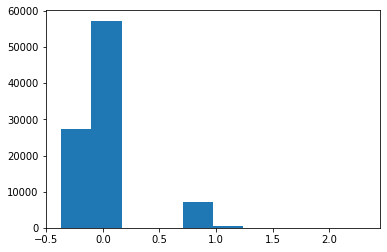

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 ) 
r2 = r2_score(y_test, lrPredict).round(4) 
print("AUC for linear regression is: ", auc)
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

def linearReports():
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)
    
    #Mean Sqaured Error:
    lrMSE=np.sqrt(metrics.mean_squared_error(y_test, lrPredict))
    print(round(lrMSE, 4), " is lr MSE ")

## Decision Tree
AUC for decision tree is:  0.74 using a number for max_leaf_nodes that reduces error.

In [11]:
from sklearn.tree import DecisionTreeRegressor

#FIND best_tree_size LEAF NODES:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=42)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        mae=get_mae(leaf, X_train, X_test, y_train, y_test)
        maeDic[leaf]=mae
    print(maeDic)
    best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_tree_size, " best_tree_size") #500 is best tree size

#calcLeaf()
best_tree_size=500
    
#MAKE PREDICTION:
tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and r2 metric:
treeR2 = r2_score(y_test, y_pred).round(4)
treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for decision tree is: ", treeAUC)

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    #Mean Sqaured Error:
    treeMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(round(treeMSE, 4), " is tree MSE ")

AUC for decision tree is:  0.74


## Logistic Regression
AUC for logistic regression is:  0.6145 with mse at 0.0709.

 The c parameter in logistic regression model by definition is the following: "Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization". Using 1 the default value for C or putting C at .01 did not change the AUC for the logistic regression.

In [12]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear') #solver param gets rid of encoder error

#Train the model and create predictions
log_reg.fit(X_train, y_train)

#use model to predict probability that given y value is 1:
log_reg_pred = log_reg.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = round(metrics.roc_auc_score(y_test, log_reg_pred), 4 ) 
print("AUC for logistic regression is: ", auc)

#Mean Squared Error
mse = mean_squared_error(y_test, log_reg_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

AUC for logistic regression is:  0.6214
The mean squared error (MSE) on test set: 0.0737


## Random Forest Regressor
Random forest AUC:  0.6312. Checking for the MAE with least error has long run-time so it is important to use checkMAE as a function only when needed. Since this is unbalanced data, r_squared provides not accurate results.

In [13]:
from sklearn.ensemble import RandomForestRegressor

#Check for Error and find Best n_estimators:
def checkMAE():
    print("Starting MAE:")
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    for n in range(2, 500, 100):
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
        print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)

    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
#checkMAE() #turn function on or off by uncommenting

#### Forest fit and predict

In [14]:
def forest():
    num=10
    forest = RandomForestRegressor(n_estimators=num, random_state = 0)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    #Print Metrics:
    forest_r2 = r2_score(y_test, y_pred).round(4)  
    forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
    print("Random forest AUC: ", forest_auc) 
    print("Random forest r2: ", forest_r2)

def forestReports():
    mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
    print("Random forest MAE: ", mae)

## K-Nearest Neighbors (KNN)
First, we must select the optimal K value with the least amount of error. When graphing the error rates, 3 is the knn that provides the least amount of error. Because the large amount of data, the KNN model runs very slow which is a big issue for KNN. If you do run the KNN model, after some time, the final AUC result is around 0.5184 which was the worse predictive model. 

In [15]:
from sklearn.neighbors import KNeighborsClassifier

def knnError():
    print("Selecting an optimal K value:")
    error_rates = []
    for i in range(1, 10, 2): #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))
    plt.figure(figsize=(16,12))
    plt.plot(error_rates)

def knnModel():
    #Train the model and make predictions:
    knn = KNeighborsClassifier(n_neighbors =3) 
    knn.fit(X_train, y_train)
    knnPredict = knn.predict_proba(X_test)[::,1]

    #calculate AUC of model
    knn_auc = round( metrics.roc_auc_score(y_test, knnPredict), 4 ) 
    print("Knn AUC: ", knn_auc)

def knnReports():
    acc = metrics.accuracy_score(y_test_data, knnPredict)
    print(confusion_matrix(y_test, knnPredict))
    print(classification_report(y_test, knnPredict))
    print(confusion_matrix(y_test, knnPredict))

## Support Vector Machine (SVM)
With many samples, SVM is extremely slow and cannot really be used. This is a major disadvantage of SVM and why some do not use it. This seems to be the case this this problem too. For more information on why SVM is slow here is a stack overflow article: https://stackoverflow.com/questions/40077432/why-is-scikit-learn-svm-svc-extremely-slow

In [16]:
def trySVM():
    from sklearn.svm import SVC
    
    #Fit and Predict:
    svc = SVC()
    svc.fit(X_train, y_train)
    svc_predit = svc.predict(X_test)

    #calculate AUC of model
    auc = round( metrics.roc_auc_score(y_test, svc_predit), 4 ) 
    print("SVC AUC is: ", auc)

def svmReports():
    print(classification_report(y_test, svc_predit))
    print(confusion_matrix(y_test, svc_predit))
    metrics.mean_absolute_error(y_test, svc_predit)
    metrics.mean_squared_error(y_test, svc_predit)
    np.sqrt(metrics.mean_squared_error(y_test, svc_predit))

# View Test Dataset 
A final prediction needs to be made for each of the 48744 cleints. The shape of the test data is (48744, 121). 

In [17]:
print(testDF.shape)
testDF.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineer Test Data
To make a final prediction, the same columns used for the train data should be used for the test data. Missing values must be filled with the mean. Dropping a column would mean a house does not get a prediction so that cannot be done.

In [18]:
features=list(X.columns)
testDF=testDF[features]
testDF=testDF.fillna(testDF.mean())
testDF.head() #5 rows × 105 columns

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769


## Predict Final Credit Risk
All 307,511 credit loans from the train dataset will get a final credit risk prediction. Since linear regression seemed to have good AUC results, I will use linear for the final prediction. 

Each SK_ID_CURR in the test set, will predict a probability for the TARGET variable. The final prediction file should contain a header and have the following format: <br><br>
SK_ID_CURR,TARGET <br/>
100001, 0.1 <br/>
100005, 0.9 <br/>
100013, 0.2 <br/>


In [19]:
test_predictions = tree.predict(testDF).round(1)
test_predictions=np.where(test_predictions<0, 0, test_predictions)
SK_ID_CURR=testDF['SK_ID_CURR']
tupleData = list(zip(SK_ID_CURR, test_predictions))
output = pd.DataFrame(tupleData, columns = ['SK_ID_CURR', 'TARGET'])
print(output.shape)
output.head()

(48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.0
1,100005,0.1
2,100013,0.0
3,100028,0.1
4,100038,0.1


## Submit Predictions
The final shape is (48744, 2), the same amount of original ID on the original test data.

In [20]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Extra: Bureau Data
The Bureau data has [1716428 rows x 17 columns]. Three columns were categorical, so they get removed. Then an additional four columns had lots of missing data, more than 80% so they are deleted. Finally, we remove a small portion of missing values just to get a general analysis of the missing data. The goal is to use this additional information outside of the train set to try to find feature importance.


In [21]:
buraeuData=r'/kaggle/input/home-credit-default-risk/bureau.csv'
buraeuDF=pd.read_csv(buraeuData) #[1716428 rows x 17 columns]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
buraeuDF = buraeuDF.select_dtypes(include=numerics) #(1716428, 14)
# Six columns have missing values:
bNA=buraeuDF.isnull().sum().sort_values(ascending=False)/len(buraeuDF) 
buraeuDF=buraeuDF.dropna(thresh=0.8*len(buraeuDF), axis=1) #(1716428, 10)
buraeuDF = buraeuDF.dropna() #(1376391, 10)
head=buraeuDF.head()